In [2]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist, cifar10


# Train custom model on CIFAR-10

## load dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes=len(class_names)

## preporcess data

In [5]:
train_images = x_train / 255
test_images = x_test / 255

train_labels = tf.keras.utils.to_categorical(y_train, num_classes)
test_labels = tf.keras.utils.to_categorical(y_test, num_classes)

## define model

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))    # num_classes = 10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

## train model

In [ ]:
# Training the model
history = model.fit(train_images, train_labels,
                    #batch_size=32,
                    epochs=20,
                    validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5850 - loss: 1.1668 - val_accuracy: 0.6353 - val_loss: 1.0325
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.6552 - loss: 0.9897 - val_accuracy: 0.6731 - val_loss: 0.9291
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6929 - loss: 0.8835 - val_accuracy: 0.6729 - val_loss: 0.9572
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7193 - loss: 0.8140 - val_accuracy: 0.7734 - val_loss: 0.6509
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7392 - loss: 0.7584 - val_accuracy: 0.7535 - val_loss: 0.7083
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7577 - loss: 0.7092 - val_accuracy: 0.7847 - val_loss: 0.6163
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7691 - loss: 0.6805 - val_accuracy: 0.8092 - val_loss: 0.5582
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7832 - loss: 0.6

In [ ]:
model.save('my_classifier.h5')

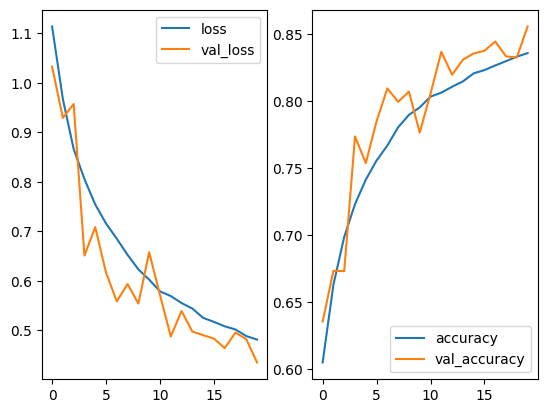

In [ ]:
plt.subplot(121)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()

In [ ]:
model_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"Accuracy: {np.round(model_acc[1]*100,2)}%")


Accuracy: 85.54%


# Adversarial Attacks

In [6]:
# load model
model = tf.keras.models.load_model('my_classifier.h5')

In [10]:
model_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"Accuracy: {np.round(model_acc[1]*100,2)}%")

Accuracy: 85.54%


## white box attack (Fast gradient sign method)

In [7]:
def generate_adversary(image, label):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)

  return sign_grad

In [8]:
img = test_images[0:1,]
label=test_labels[0:1,]

perturbations = generate_adversary(img,label).numpy()
adversarial = img + (perturbations * 0.05)

pred_label= np.argmax(model(img))
pred_label_adv= np.argmax(model(adversarial))


Text(0.5, 1.0, 'Image with Adversary: frog')

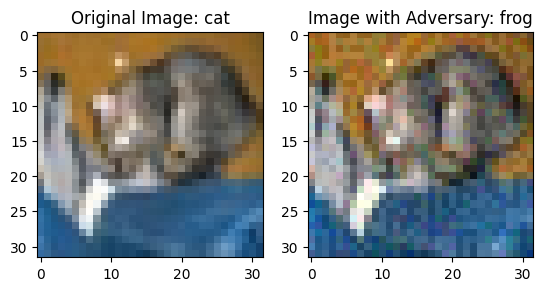

In [9]:
plt.subplot(121)
plt.imshow(img[0,])
plt.title("Original Image: "+class_names[pred_label])
plt.subplot(122)
plt.imshow(adversarial[0])
plt.title("Image with Adversary: "+class_names[pred_label_adv])

### accuracy of adversary test dataset

In [17]:
test_images_adv=np.zeros(test_images.shape)

for i in range(len(test_images)//10):
  img  = test_images[i:i+10,]
  label= test_labels[i:i+10,]

  perturbations = generate_adversary(img,label).numpy()
  adversarial = img + (perturbations * 0.05)

  test_images_adv[i:i+10,]=adversarial

In [18]:
model_acc_adv = model.evaluate(test_images_adv, test_labels, verbose=0)
print(f"Accuracy: {np.round(model_acc_adv[1]*100,2)}%")


Accuracy: 9.69%


# compare accuracy

Text(0, 0.5, 'accuracy')

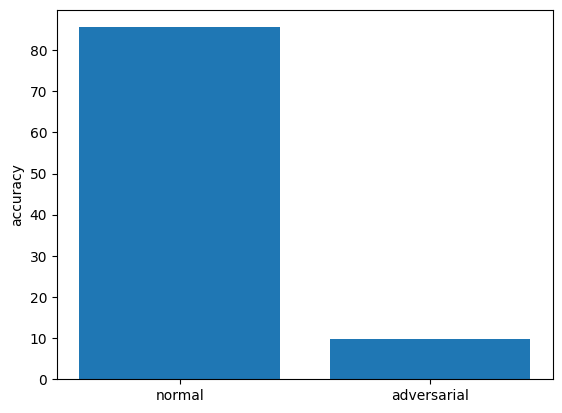

In [19]:
plt.bar([1,2],[model_acc[1]*100,model_acc_adv[1]*100])
plt.xticks([1, 2], ['normal', 'adversarial'])
plt.ylabel('accuracy')